# Particle Filtering with **QInfer** #
**Christopher Granade**, University of Sydney.<br />
Based on a tutorial by **Christopher Ferrie**.

Quantum Machine Learning Workshop 2016 <br/>
Perimeter Institute

---

## Introduction ##

In this Notebook, we will introduce Bayesian parameter estimation and the particle filter algorithm implemented by **QInfer**. To this end, suppose we have a coin that we do not know the bias $p$ of. We will guess what $p$ is by flipping the coin many times. 

If we knew the bias, we could determine the exact distribution of the number of "Heads" we would see. If we label the number of flips $N$ and the number of heads $n$, then the distribution of $n$ is of course a Binomial distribution
$$
\operatorname{Pr}(n|p) = \binom{N}{n} p^n (1-p)^{N-n}.
$$

Now suppose we have flipped the coin and $n$ heads did actually occur in $N$ flips. What is the distribution of $p|n$? The answer is given by Bayes' rule:
$$
\operatorname{Pr}(n|p) = \frac{\operatorname{Pr}(n|p)\operatorname{Pr}(p)}{\operatorname{Pr}(n)},
$$
where $\operatorname{Pr}(n|p)$ is called the likelihood function, $\operatorname{Pr}(p)$ the prior, $\operatorname{Pr}(p|n)$ the posterior and $\operatorname{Pr}(n)$ is called the evidence. The likelihood function we have determined above. The prior is the input to the problem and the evidence can be determined by normalization of probability.

The input, the prior, can be anything. A typical choice for generic problems is the uniform prior $\operatorname{Pr}(p) = 1/V$, where $V$ is the volume of the parameter space, in this case $V = 1$ since the bias can be between 0 and 1. For the uniform prior, the posterior is
$$
\operatorname{Pr}(p|n) = \frac{p^n (1-p)^{N-n}}{B(n+1,N-n+1)},
$$
where $B$ is the Beta function.

For more complicated models, such an analytic solution is not obtainable and we must turn to numerical algorithms. The algorithm we use is called sequential Monte Carlo or the particle filter. We begin by drawing $k$ samples $\{p_i\}$ from the prior and approximating it as
$$
\operatorname{Pr}(p) = \frac{1}{k}\sum_{i=1}^k \delta(p-p_i).
$$
The samples are called particles. Each particle is associated a weight $w_i$ which is conventionally set to be $1/k$ initially. The weights are updated via Bayes rule as follows:
$$
w_i(n) \mapsto \Pr(n|p_i)/k.
$$
The set of weights $\{w_i(n)\}$ are not normalized so we make one final assignment
$$
w_i(n) \mapsto \frac{w_i(n)}{\sum_j w_j(n)}.
$$
Then the posterior is approximated by
$$
\operatorname{Pr}(p) = \sum_{i=1}^k w_i(n) \delta(p-p_i).
$$

That's it; that's the basics! Now we will go through it a little more slowly using numpy, scipy and qinfer.

## Installation ##

If you wish to install into your existing Python or Anaconda environment, simply run the following:

    $ pip install qinfer
    
For this tutorial, however, we recommend creating a fresh Anaconda environment to avoid incompatabilities.

    $ conda create -n=qinfer-tutorial  python=3.5 numpy scipy matplotlib jupyter
    
To activate your new environment, run

    $ source activate qinfer-tutorial

on Linux, OS X or Ubuntu for Windows, and run 

    > activate qinfer-tutorial
    
on Windows. Once you have activated the new environment, install QInfer as normal.

    $ pip install qinfer

## Running Jupyter ##

With the appropriate environment activated, run Jupyter Notebook:

    $ jupyter notebook

## Preamble ##

Here we import all the necessary modules as well as make the code compatible with Python 2.7. This may generate some warnings; that's OK. Jupyter and **QInfer** are letting us know which optional libraries are missing.

In [1]:
from __future__ import division, print_function

import qinfer as qi
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
# Use nice plotting defaults if available.
try: plt.style.use('ggplot')
except: pass

C:\Anaconda2\envs\qinfer-tutorial\lib\site-packages\qinfer\metrics.py:51: UserWarning: Could not import scikit-learn. Some features may not work.
  warnings.warn("Could not import scikit-learn. Some features may not work.")
C:\Anaconda2\envs\qinfer-tutorial\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Anaconda2\envs\qinfer-tutorial\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
C:\Anaconda2\envs\qinfer-tutorial\lib\site-packages\qinfer\parallel.py:53: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


### Flipping coins

Suppose we flip our coin 10 times. What does $\operatorname{Pr}(n|p)$ look like?

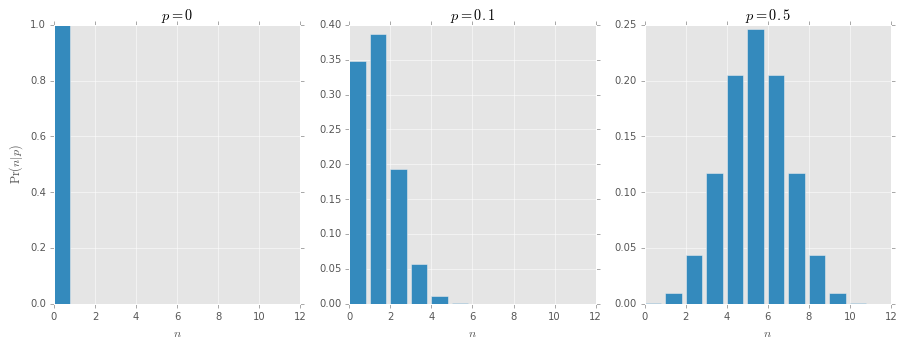

In [2]:
# Create a variable for the number of flips (go ahead and change this if you want).
N = 10
# This creates an array containing [0, 1, ..., N].
n = np.arange(0, N + 1)

# This sets up the figure as an matrix of subfigures with 1 row and 3 columns.
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
# This is the probability mass function (pmf) of the binomial distribution for p = 0.
dist = sp.stats.binom.pmf(n, N, 0)
# On the first (0 indexed!) subplot, make a bar plot with x-axis given by the array n and y-axis given by the pmf.
axarr[0].bar(n, dist)

# The rest is just annotation and repeating for different biases.
axarr[0].set_xlabel("$n$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$p = 0$")

dist = sp.stats.binom.pmf(n, N, 0.1)
axarr[1].bar(n, dist)
axarr[1].set_xlabel("$n$")
axarr[1].set_title("$p = 0.1$")

dist = sp.stats.binom.pmf(n, N, 0.5)
axarr[2].bar(n, dist)
axarr[2].set_xlabel("$n$")
axarr[2].set_title("$p = 0.5$")


In reality, we often have data, in this case $n$, so we are interested not in $\operatorname{Pr}(n|p)$ but in $\operatorname{Pr}(p|n)$. We still use $\operatorname{Pr}(n|p)$ in Bayes' rule but think of it as a function of $p$ for fixed data $n$. Below we plot what that looks like.

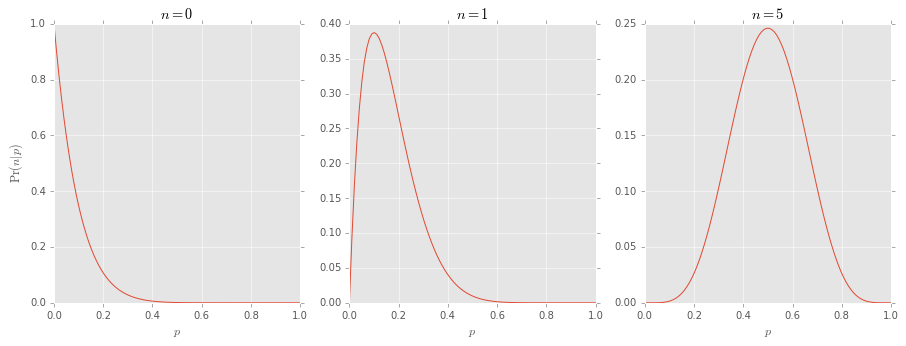

In [3]:
 # This creates an array with 100 values between 0 and 1.
p = np.linspace(0, 1, 100)

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
likelihood = sp.stats.binom.pmf(0, N, p)
axarr[0].plot(p, likelihood)
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(n|p)$")
axarr[0].set_title("$n = 0$")

likelihood = sp.stats.binom.pmf(1, N, p)
axarr[1].plot(p, likelihood)
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n = 1$")

likelihood = sp.stats.binom.pmf(5, N, p)
axarr[2].plot(p, likelihood)
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n = 5$")

Bayes' rule states:
$$
\operatorname{Pr}(p|n) = \frac{\operatorname{Pr}(n|p)\operatorname{Pr}(p)}{\operatorname{Pr}(n)} = \frac{p^n (1-p)^{N-n}}{B(n+1,N-n+1)},
$$
For the uniform prior $\operatorname{Pr}(p) = 1$. Since this is just proportional to $\operatorname{Pr}(p|n)$ we should expect the posterior to look the same.

(Note that $\operatorname{Pr}(p|n)$ is not strictly a probability, but a density, or measure, and can be greater than 1 for any particular value of $p$ since only questions about the probability over intervals return non-zero answers.)

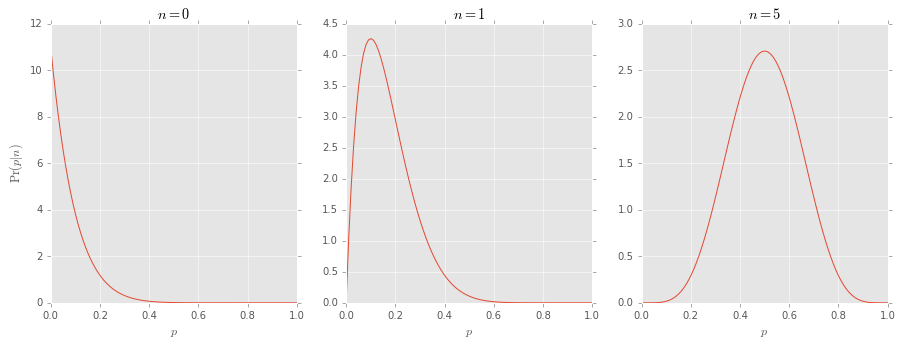

In [4]:
# Rather than write it out many times, we define a function to compute the posterior which compresses further code.
def posterior(p, n, N):
    return p ** n * (1 - p) ** (N - n) / sp.special.beta(n + 1, N - n + 1)

# Note that notebooks have access to the variables defined in previous run cells, so we do not need to redefine N and p.
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
axarr[0].plot(p, posterior(p, 0, N))
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(p | n)$")
axarr[0].set_title("$n = 0$")

axarr[1].plot(p, posterior(p, 1, N))
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n = 1$")

axarr[2].plot(p, posterior(p, 5, N))
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n = 5$")

### QInfer

Now we will demonstrate how to use **QInfer** to get a numerical approximation to the posterior. The first task is create a `Model`.

In [5]:
# We create a model which is abstracted by the Model class, which already implements common methods 
# among models and templates what such a class needs to look like

class CoinFlipsModel(qi.Model):
    
    # This function is called when an instance of this class is instantiated.
    def __init__(self):
        # Make sure all the necessary functionality in the Model class is brought over.
        super(CoinFlipsModel, self).__init__()
        
    # The following are functions that are required for the functionality of QInfer.
    
    @property
    def n_modelparams(self):
        # The dimension of the parameter space.
        return 1 # In this case, it is just the bias p.
    
    @property
    def expparams_dtype(self):
        # many models will have complicated experiment design descriptions. Here, it is just the number of flips.
        return int # The number of flips is an integer.
    
    def n_outcomes(self, expparams):
        # The number of outcomes are needed to numerically simulate experiments.
        return expparams + 1 # the number of flips + 1
    
    def are_models_valid(self, modelparams):
        # Make sure any boundaries in the parameter space are respected.
        # In this case, the modelparams array is a bias, which must be between 0 and 1.
        return np.logical_or(modelparams >= 0, modelparams <= 1)[:, 0]
    
    def likelihood(self, outcomes, modelparams, expparams):
        # Finally, we calculate the likelihood function
        # Again, call some necessary internal functions.
        super(CoinFlipsModel,self).likelihood(outcomes, modelparams, expparams)
        
        # The tensor storing the values of the likelihood has the following expected shape.
        like = np.zeros([outcomes.shape[0], modelparams.shape[0], 1])
        
        # scipy.stats.binom can vectorize over one of its arguments so we'll have to loop over the other
        for idx in range(outcomes.shape[0]):
            like[idx] = sp.stats.binom.pmf(outcomes[idx], expparams, modelparams)
            
        return like

Now that is a bit overkill for such a simple problem, but the functionality is there really for more "interesting" models. But we can see that calling `model.likelihood` gives the correct results.

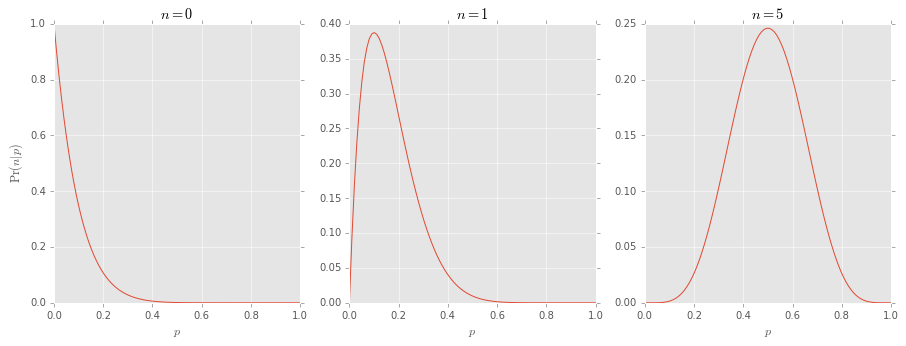

In [6]:
model = CoinFlipsModel() # This instantiates the model we just defined.

# Recall that model.expparams_dtype was int and we defined N to be an integer above.
expparams = np.array([N], dtype=model.expparams_dtype)
# In the model we asked for outcomes.shape[0], so we have to define it as an object with a shape!
outcome = np.array([0])

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))
# Note that modelparams are expected to have at least 2D shape;
# indexing by None adds an axis to the (100,) array we defined above for p.
axarr[0].plot(p, model.likelihood(outcome, p[:, None], expparams)[0, :, 0]) 
axarr[0].set_xlabel("$p$")
axarr[0].set_ylabel("$\operatorname{Pr}(n | p)$")
axarr[0].set_title("$n = 0$")

outcome = np.array([1])
axarr[1].plot(p, model.likelihood(outcome, p[:, None], expparams)[0, :, 0])
axarr[1].set_xlabel("$p$")
axarr[1].set_title("$n = 1$")

outcome = np.array([5])
axarr[2].plot(p, model.likelihood(outcome, p[:, None], expparams)[0, :, 0])
axarr[2].set_xlabel("$p$")
axarr[2].set_title("$n = 5$")

The next step is creating a distribution. For most (and by most, I mean nearly all) distributions used in practice, there is built-in functionality. In particular, the uniform prior discussed above is defined in QInfer as follows. 

In [7]:
# This instantiates the built-in uniform prior over the interval [0, 1].
prior = qi.UniformDistribution([0, 1])
# prior.sample() returns a single randomly drawn sample.
print(prior.sample())

[[ 0.86006411]]


The last thing to do is define an `SMCUpdater` which implements the sequential Monte Carlo algorithm. An `SMCUpdater` takes a `model` and `prior` and then its `update` function takes data and experiment parameters to produce the posterior distribution. The number of particles used controls the approximation.

In [8]:
# The number of particles we will use.
n_particles = 1000

# Instantiates an updater, takes the model and prior we defined above.
updater = qi.smc.SMCUpdater(model, n_particles, prior)

OK, now we can plug in some data and see how well it does.

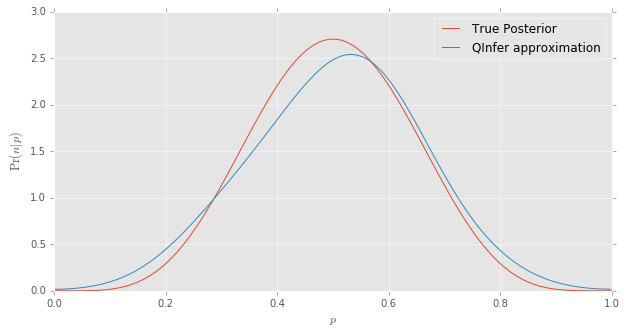

In [9]:
# In the model we asked for outcomes.shape[0], so we have to define it as an object with a shape!
outcome = np.array([5])

# Call the update function to change the state of the updater, now it stores the posterior.
updater.update(outcome, expparams)

plt.figure(figsize=(10, 5))

plt.plot(p, posterior(p, 5, N), label = 'True Posterior')
updater.plot_posterior_marginal(smoothing=0.075, other_plot_args={'label': 'QInfer approximation'})

plt.xlabel("$p$")
plt.ylabel("$\operatorname{Pr}(n|p)$")

plt.legend()

## Hamiltonian Learning and the Updater Loop ##

The update we performed above forms the core of the *updater loop* concept.

![](figures/bayesian-pe-flowchart.svg)

Let's play with this concept further by learning a simple Hamiltonian, $H = \omega \sigma_z / 2$ for an unknown $\omega$. We'll consider an experiment in which one prepares the state $\left|+\right\rangle \propto \left|0\right\rangle + \left|1\right\rangle$, evolves under $H$ for some time $t$, then measures. This is implemented by the ``SimplePrecessionModel`` class in **QInfer**, so let's create that model now.

In [10]:
model = qi.SimplePrecessionModel()

We'll presume that our prior is initially a uniform distribution on $[0, 1]$, and will draw a "true" model from that prior. We'll later use the true model to simulate data.

In [11]:
prior = qi.UniformDistribution([0, 1])
true_modelparams = prior.sample()

As before, we now create an updater for this model and prior.

In [12]:
updater = qi.smc.SMCUpdater(model, 2000, prior)

Next, we create a *heuristic* that implements exponentially sparse sampling $t_k = ab^k$.

In [13]:
heuristic = qi.ExpSparseHeuristic(updater)

Finally, we have everything we need to iterate over data, using each datum to update our posterior. In doing so, we'll our heuristic to design new experiments, and will use the model class to simulate new experimental data.

In [14]:
for idx_experiment in range(50):
    experiment = heuristic()
    datum = model.simulate_experiment(true_modelparams, experiment)
    updater.update(datum, experiment)

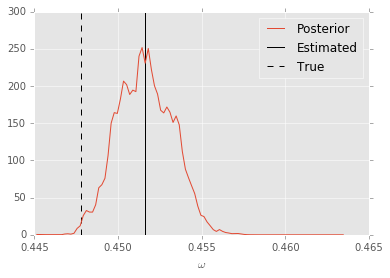

In [15]:
updater.plot_posterior_marginal(res=100, other_plot_args={'label': 'Posterior'})
ylim = plt.ylim()
plt.vlines(updater.est_mean(), *ylim, label='Estimated')
plt.vlines(true_modelparams, *ylim, linestyles='--', label='True')
plt.legend(loc='best')
plt.ylim(*ylim);

## More QInfer Examples ##

**QInfer** has been applied in practice to support reproducible research practices. For example,

- [Figures for *Practical Bayesian tomography*, Granade et al. 2016](http://nbviewer.jupyter.org/gist/cgranade/9b3f8c4c8173eebf5f35/QInfer%20Tomography%20Tutorial.ipynb).
- [Supplemental material for *Accelerated randomized benchmarking*, 